In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
import csv
import numpy as np  
import pandas as pd 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score

f = './new_28.csv'
dataset = pd.read_csv(f ,names = ['alpha','PIR', 'ptt', 'bpmax' ,'bpmin', 'hrfinal', 'ih', 'il', 'meu', 'ST10', 'ST10+DT10','ST10/DT10', 'ST25', 'ST25+DT25','ST25/DT25', 'ST33', 'ST33+DT33','ST33/DT33','ST50','ST50+DT50','ST50/DT50','ST66+DT66','ST75+DT75','ST','DT'])
X = dataset[['alpha','PIR', 'ptt', 'hrfinal', 'ih', 'il', 'meu', 'ST10', 'ST10+DT10','ST10/DT10', 'ST25', 'ST25+DT25','ST25/DT25', 'ST33', 'ST33+DT33','ST33/DT33','ST50','ST50+DT50','ST50/DT50','ST66+DT66','ST75+DT75','ST','DT']]
y = dataset[['bpmin','bpmax']] # SBP, DBP

sbp = list()
dbp = list()
real_BP = list()
h=0
d=0
with open(f, 'r') as csvfile:
    csv_reader = csv.reader(csvfile, delimiter = ',')
    for row in csv_reader:
        if(float(row[3])>=180 or float(row[3])<=80 or float(row[4])>=130 or float(row[4])<=60):
            X = X.drop(d)
            h+=1
        else:
            sbp.append(float(row[3]))
            dbp.append(float(row[4]))
        d+=1
    print("delete data: " , h)
    for i in range(len(sbp)):
        BP_actual = (2*dbp[i] + sbp[i])/3
        real_BP.append(BP_actual)
    print("real_BP.len: ", len(real_BP))

delete data:  5135
real_BP.len:  4631


In [3]:
from sklearn import preprocessing

minmax = preprocessing.MinMaxScaler()
standscaler = preprocessing.StandardScaler()

X = minmax.fit_transform(X) # maxmin正規化
#X = standscaler.fit_transform(X) # z正規化

X_train, X_test, y_train, y_test = train_test_split(X, real_BP, test_size=0.1, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, sbp, test_size=0.1, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, dbp, test_size=0.1, random_state=1)

a = np.array(X_train)
a.reshape(-1,1)
print(a.shape)
b = np.array(y_train)
print(b.shape)
c = np.array(X_test)
c.reshape(-1,1)
print(c.shape)
d = np.array(y_test)
print(d.shape)

(4167, 23)
(4167,)
(464, 23)
(464,)


In [12]:
import keras
from shutil import copyfile
copyfile(src = "./DefuzzyLayer.py", dst = "Defuzzy_Layer.py")
copyfile(src = "./FuzzyLayer.py", dst = "Fuzzy_Layer.py")
copyfile(src = "./fusion_method.py", dst = "Fusion_Layer.py")
from FuzzyLayer import FuzzyLayer
from DefuzzyLayer import DefuzzyLayer
from fusion_method import fusion
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Dropout, Input
from keras.layers.convolutional import MaxPooling2D,Conv1D,MaxPooling1D
from keras.layers.core import Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling1D, GlobalMaxPool1D, MaxPool1D, AveragePooling1D



def FNN_model():
    inp = Input(shape=(23, 1))
    x = Conv1D(filters=20,kernel_size =2, strides=1, activation='relu')(inp)
    x = Conv1D(filters=10,kernel_size =2, strides=1, activation='relu')(x)
    x = BatchNormalization()(x)
    x=fusion(1, x, 1) #1:CAP/2:GAP/3:CMP/4:GMP
    x=FuzzyLayer(5)(x)
    x=DefuzzyLayer(1)(x)
    model=Model(inp, x)
    return model

model = FNN_model()
model.compile(loss="MAE", optimizer="Adam",metrics=["mse"])
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 23, 1)]           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 22, 20)            60        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 21, 10)            410       
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 10)            40        
_________________________________________________________________
tf_op_layer_Mean_2 (TensorFl [(None, 21)]              0         
_________________________________________________________________
fuzzy_layer_2 (FuzzyLayer)   (None, 5)                 210       
_________________________________________________________________
defuzzy_layer_2 (DefuzzyLaye (None, 1)                

In [13]:
history = model.fit(a, b, epochs = 1000, batch_size = 128, verbose = 1, validation_split=0.1)

Epoch 1/1000
30/30 [==============================] - 0s 13ms/step - loss: 90.3572 - mse: 8320.7881 - val_loss: 90.8084 - val_mse: 8396.4619
Epoch 2/1000
30/30 [==============================] - 0s 6ms/step - loss: 90.2510 - mse: 8301.6162 - val_loss: 90.6545 - val_mse: 8368.5215
Epoch 3/1000
30/30 [==============================] - 0s 5ms/step - loss: 90.0537 - mse: 8266.0635 - val_loss: 90.4646 - val_mse: 8334.1250
Epoch 4/1000
30/30 [==============================] - 0s 5ms/step - loss: 89.8578 - mse: 8230.7881 - val_loss: 90.2802 - val_mse: 8300.8037
Epoch 5/1000
30/30 [==============================] - 0s 6ms/step - loss: 89.6772 - mse: 8198.3682 - val_loss: 90.1051 - val_mse: 8269.2256
Epoch 6/1000
30/30 [==============================] - 0s 6ms/step - loss: 89.5047 - mse: 8167.4780 - val_loss: 89.9360 - val_mse: 8238.7627
Epoch 7/1000
30/30 [==============================] - 0s 10ms/step - loss: 89.3371 - mse: 8137.5029 - val_loss: 89.7705 - val_mse: 8209.0254
Epoch 8/1000
30/30

30/30 [==============================] - 0s 5ms/step - loss: 81.3780 - mse: 6778.7651 - val_loss: 81.8178 - val_mse: 6844.4351
Epoch 60/1000
30/30 [==============================] - 0s 5ms/step - loss: 81.2274 - mse: 6754.2549 - val_loss: 81.6666 - val_mse: 6819.7124
Epoch 61/1000
30/30 [==============================] - 0s 5ms/step - loss: 81.0768 - mse: 6729.8052 - val_loss: 81.5155 - val_mse: 6795.0630
Epoch 62/1000
30/30 [==============================] - 0s 5ms/step - loss: 80.9262 - mse: 6705.4482 - val_loss: 81.3648 - val_mse: 6770.5166
Epoch 63/1000
30/30 [==============================] - 0s 6ms/step - loss: 80.7758 - mse: 6681.1260 - val_loss: 81.2149 - val_mse: 6746.1401
Epoch 64/1000
30/30 [==============================] - 0s 5ms/step - loss: 80.6252 - mse: 6656.7842 - val_loss: 81.0633 - val_mse: 6721.5508
Epoch 65/1000
30/30 [==============================] - 0s 4ms/step - loss: 80.4748 - mse: 6632.5459 - val_loss: 80.9169 - val_mse: 6697.8271
Epoch 66/1000
30/30 [======

Epoch 117/1000
30/30 [==============================] - 0s 5ms/step - loss: 72.6625 - mse: 5436.2305 - val_loss: 73.1010 - val_mse: 5494.0420
Epoch 118/1000
30/30 [==============================] - 0s 6ms/step - loss: 72.5124 - mse: 5414.4316 - val_loss: 72.9508 - val_mse: 5472.1001
Epoch 119/1000
30/30 [==============================] - 0s 5ms/step - loss: 72.3623 - mse: 5392.7212 - val_loss: 72.8016 - val_mse: 5450.3599
Epoch 120/1000
30/30 [==============================] - 0s 5ms/step - loss: 72.2122 - mse: 5370.9907 - val_loss: 72.6511 - val_mse: 5428.4707
Epoch 121/1000
30/30 [==============================] - 0s 5ms/step - loss: 72.0621 - mse: 5349.3423 - val_loss: 72.5005 - val_mse: 5406.6035
Epoch 122/1000
30/30 [==============================] - 0s 5ms/step - loss: 71.9120 - mse: 5327.7017 - val_loss: 72.3510 - val_mse: 5384.9473
Epoch 123/1000
30/30 [==============================] - 0s 5ms/step - loss: 71.7619 - mse: 5306.1816 - val_loss: 72.2039 - val_mse: 5363.6978
Epoch 

Epoch 175/1000
30/30 [==============================] - 0s 5ms/step - loss: 63.9599 - mse: 4247.2207 - val_loss: 64.3983 - val_mse: 4297.4326
Epoch 176/1000
30/30 [==============================] - 0s 5ms/step - loss: 63.8099 - mse: 4228.0981 - val_loss: 64.2501 - val_mse: 4278.3682
Epoch 177/1000
30/30 [==============================] - 0s 5ms/step - loss: 63.6599 - mse: 4208.9629 - val_loss: 64.0990 - val_mse: 4258.9736
Epoch 178/1000
30/30 [==============================] - 0s 5ms/step - loss: 63.5099 - mse: 4189.8594 - val_loss: 63.9514 - val_mse: 4240.0664
Epoch 179/1000
30/30 [==============================] - 0s 5ms/step - loss: 63.3599 - mse: 4170.8379 - val_loss: 63.7983 - val_mse: 4220.5107
Epoch 180/1000
30/30 [==============================] - ETA: 0s - loss: 63.1427 - mse: 4141.391 - 0s 5ms/step - loss: 63.2099 - mse: 4151.8721 - val_loss: 63.6492 - val_mse: 4201.5107
Epoch 181/1000
30/30 [==============================] - 0s 5ms/step - loss: 63.0599 - mse: 4132.9385 - val

Epoch 232/1000
30/30 [==============================] - 0s 5ms/step - loss: 55.4105 - mse: 3226.7214 - val_loss: 55.8607 - val_mse: 3270.7068
Epoch 233/1000
30/30 [==============================] - 0s 5ms/step - loss: 55.2605 - mse: 3210.0803 - val_loss: 55.7019 - val_mse: 3252.9922
Epoch 234/1000
30/30 [==============================] - 0s 5ms/step - loss: 55.1105 - mse: 3193.5066 - val_loss: 55.5521 - val_mse: 3236.3262
Epoch 235/1000
30/30 [==============================] - 0s 5ms/step - loss: 54.9605 - mse: 3177.0461 - val_loss: 55.3998 - val_mse: 3219.4207
Epoch 236/1000
30/30 [==============================] - 0s 5ms/step - loss: 54.8105 - mse: 3160.5444 - val_loss: 55.2497 - val_mse: 3202.8162
Epoch 237/1000
30/30 [==============================] - 0s 5ms/step - loss: 54.6605 - mse: 3144.1318 - val_loss: 55.0998 - val_mse: 3186.2722
Epoch 238/1000
30/30 [==============================] - 0s 5ms/step - loss: 54.5105 - mse: 3127.7578 - val_loss: 54.9492 - val_mse: 3169.7014
Epoch 

Epoch 290/1000
30/30 [==============================] - 0s 5ms/step - loss: 46.7094 - mse: 2338.1506 - val_loss: 47.1490 - val_mse: 2373.3162
Epoch 291/1000
30/30 [==============================] - 0s 5ms/step - loss: 46.5593 - mse: 2324.1533 - val_loss: 46.9978 - val_mse: 2359.0830
Epoch 292/1000
30/30 [==============================] - 0s 5ms/step - loss: 46.4092 - mse: 2310.2129 - val_loss: 46.8476 - val_mse: 2344.9824
Epoch 293/1000
30/30 [==============================] - 0s 5ms/step - loss: 46.2592 - mse: 2296.3130 - val_loss: 46.7110 - val_mse: 2332.2029
Epoch 294/1000
30/30 [==============================] - 0s 5ms/step - loss: 46.1091 - mse: 2282.4128 - val_loss: 46.5563 - val_mse: 2317.7771
Epoch 295/1000
30/30 [==============================] - 0s 5ms/step - loss: 45.9590 - mse: 2268.6187 - val_loss: 46.4030 - val_mse: 2303.5288
Epoch 296/1000
30/30 [==============================] - 0s 5ms/step - loss: 45.8090 - mse: 2254.8513 - val_loss: 46.2507 - val_mse: 2289.4153
Epoch 

30/30 [==============================] - 0s 5ms/step - loss: 38.1559 - mse: 1612.2361 - val_loss: 38.5943 - val_mse: 1639.8060
Epoch 348/1000
30/30 [==============================] - 0s 5ms/step - loss: 38.0058 - mse: 1600.7877 - val_loss: 38.4516 - val_mse: 1628.8138
Epoch 349/1000
30/30 [==============================] - 0s 5ms/step - loss: 37.8558 - mse: 1589.4580 - val_loss: 38.3019 - val_mse: 1617.3242
Epoch 350/1000
30/30 [==============================] - 0s 5ms/step - loss: 37.7057 - mse: 1578.0945 - val_loss: 38.1522 - val_mse: 1605.8771
Epoch 351/1000
30/30 [==============================] - 0s 5ms/step - loss: 37.5556 - mse: 1566.8015 - val_loss: 37.9945 - val_mse: 1593.8718
Epoch 352/1000
30/30 [==============================] - 0s 5ms/step - loss: 37.4056 - mse: 1555.5616 - val_loss: 37.8456 - val_mse: 1582.5746
Epoch 353/1000
30/30 [==============================] - 0s 5ms/step - loss: 37.2555 - mse: 1544.3378 - val_loss: 37.6952 - val_mse: 1571.2162
Epoch 354/1000
30/30 

Epoch 405/1000
30/30 [==============================] - 0s 5ms/step - loss: 29.4524 - mse: 1023.8167 - val_loss: 29.8913 - val_mse: 1043.7771
Epoch 406/1000
30/30 [==============================] - 0s 5ms/step - loss: 29.3023 - mse: 1015.0115 - val_loss: 29.7414 - val_mse: 1034.8395
Epoch 407/1000
30/30 [==============================] - 0s 5ms/step - loss: 29.1522 - mse: 1006.2202 - val_loss: 29.5911 - val_mse: 1025.9221
Epoch 408/1000
30/30 [==============================] - 0s 5ms/step - loss: 29.0022 - mse: 997.4843 - val_loss: 29.4405 - val_mse: 1017.0327
Epoch 409/1000
30/30 [==============================] - 0s 5ms/step - loss: 28.8521 - mse: 988.8000 - val_loss: 29.2905 - val_mse: 1008.2234
Epoch 410/1000
30/30 [==============================] - 0s 5ms/step - loss: 28.7021 - mse: 980.1773 - val_loss: 29.1404 - val_mse: 999.4510
Epoch 411/1000
30/30 [==============================] - 0s 5ms/step - loss: 28.5520 - mse: 971.5924 - val_loss: 28.9905 - val_mse: 990.7339
Epoch 412/10

30/30 [==============================] - 0s 5ms/step - loss: 20.7557 - mse: 587.0335 - val_loss: 21.2097 - val_mse: 599.9191
Epoch 464/1000
30/30 [==============================] - 0s 5ms/step - loss: 20.6064 - mse: 580.8244 - val_loss: 21.0537 - val_mse: 593.2629
Epoch 465/1000
30/30 [==============================] - 0s 5ms/step - loss: 20.4574 - mse: 574.6951 - val_loss: 20.9023 - val_mse: 586.8542
Epoch 466/1000
30/30 [==============================] - 0s 5ms/step - loss: 20.3087 - mse: 568.6082 - val_loss: 20.7540 - val_mse: 580.5878
Epoch 467/1000
30/30 [==============================] - 0s 5ms/step - loss: 20.1603 - mse: 562.5489 - val_loss: 20.6073 - val_mse: 574.4333
Epoch 468/1000
30/30 [==============================] - 0s 5ms/step - loss: 20.0126 - mse: 556.5756 - val_loss: 20.4604 - val_mse: 568.3199
Epoch 469/1000
30/30 [==============================] - 0s 5ms/step - loss: 19.8656 - mse: 550.6719 - val_loss: 20.3130 - val_mse: 562.2244
Epoch 470/1000
30/30 [=============

30/30 [==============================] - 0s 5ms/step - loss: 13.5482 - mse: 317.7841 - val_loss: 13.9138 - val_mse: 323.3779
Epoch 522/1000
30/30 [==============================] - 0s 5ms/step - loss: 13.4601 - mse: 314.6619 - val_loss: 13.8214 - val_mse: 320.1738
Epoch 523/1000
30/30 [==============================] - 0s 5ms/step - loss: 13.3733 - mse: 311.5729 - val_loss: 13.7297 - val_mse: 317.0222
Epoch 524/1000
30/30 [==============================] - 0s 5ms/step - loss: 13.2875 - mse: 308.6011 - val_loss: 13.6383 - val_mse: 313.8990
Epoch 525/1000
30/30 [==============================] - 0s 5ms/step - loss: 13.2037 - mse: 305.6347 - val_loss: 13.5495 - val_mse: 310.8402
Epoch 526/1000
30/30 [==============================] - 0s 5ms/step - loss: 13.1219 - mse: 302.7274 - val_loss: 13.4625 - val_mse: 307.8355
Epoch 527/1000
30/30 [==============================] - 0s 5ms/step - loss: 13.0414 - mse: 299.8452 - val_loss: 13.3760 - val_mse: 304.8596
Epoch 528/1000
30/30 [=============

30/30 [==============================] - 0s 5ms/step - loss: 10.4888 - mse: 202.4326 - val_loss: 10.6154 - val_mse: 203.0022
Epoch 580/1000
30/30 [==============================] - 0s 6ms/step - loss: 10.4647 - mse: 201.3292 - val_loss: 10.5891 - val_mse: 201.8464
Epoch 581/1000
30/30 [==============================] - 0s 5ms/step - loss: 10.4410 - mse: 200.2764 - val_loss: 10.5639 - val_mse: 200.7500
Epoch 582/1000
30/30 [==============================] - 0s 4ms/step - loss: 10.4187 - mse: 199.2386 - val_loss: 10.5392 - val_mse: 199.6392
Epoch 583/1000
30/30 [==============================] - 0s 5ms/step - loss: 10.3964 - mse: 198.2092 - val_loss: 10.5154 - val_mse: 198.5268
Epoch 584/1000
30/30 [==============================] - 0s 5ms/step - loss: 10.3751 - mse: 197.2030 - val_loss: 10.4953 - val_mse: 197.5808
Epoch 585/1000
30/30 [==============================] - 0s 4ms/step - loss: 10.3539 - mse: 196.2318 - val_loss: 10.4775 - val_mse: 196.7456
Epoch 586/1000
30/30 [=============

Epoch 638/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.8525 - mse: 168.2347 - val_loss: 9.7945 - val_mse: 165.4272
Epoch 639/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.8493 - mse: 167.5574 - val_loss: 9.8287 - val_mse: 167.1281
Epoch 640/1000
30/30 [==============================] - 0s 6ms/step - loss: 9.8459 - mse: 167.4420 - val_loss: 9.8062 - val_mse: 166.4564
Epoch 641/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.8418 - mse: 167.4286 - val_loss: 9.7754 - val_mse: 165.0022
Epoch 642/1000
30/30 [==============================] - 0s 4ms/step - loss: 9.8388 - mse: 167.1026 - val_loss: 9.7766 - val_mse: 165.0206
Epoch 643/1000
30/30 [==============================] - 0s 4ms/step - loss: 9.8348 - mse: 166.9111 - val_loss: 9.7765 - val_mse: 165.3328
Epoch 644/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.8338 - mse: 166.6861 - val_loss: 9.7802 - val_mse: 165.4461
Epoch 645/1000
30/30 [============

30/30 [==============================] - 0s 5ms/step - loss: 9.7789 - mse: 162.3683 - val_loss: 9.6603 - val_mse: 159.8591
Epoch 698/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7783 - mse: 162.7700 - val_loss: 9.6614 - val_mse: 159.9557
Epoch 699/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7785 - mse: 162.0731 - val_loss: 9.6614 - val_mse: 160.0088
Epoch 700/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7782 - mse: 162.7132 - val_loss: 9.6618 - val_mse: 159.8595
Epoch 701/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7780 - mse: 162.5670 - val_loss: 9.6588 - val_mse: 159.8515
Epoch 702/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7798 - mse: 161.7627 - val_loss: 9.6661 - val_mse: 160.2678
Epoch 703/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7767 - mse: 162.4290 - val_loss: 9.6588 - val_mse: 159.5524
Epoch 704/1000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 9.7511 - mse: 161.4395 - val_loss: 9.6611 - val_mse: 160.3014
Epoch 757/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7506 - mse: 160.8736 - val_loss: 9.6500 - val_mse: 159.6233
Epoch 758/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7504 - mse: 160.8956 - val_loss: 9.6629 - val_mse: 160.4890
Epoch 759/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7494 - mse: 160.8823 - val_loss: 9.6332 - val_mse: 158.1399
Epoch 760/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7451 - mse: 161.0674 - val_loss: 9.6294 - val_mse: 157.6148
Epoch 761/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7468 - mse: 160.6481 - val_loss: 9.6295 - val_mse: 157.5112
Epoch 762/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.7460 - mse: 161.2452 - val_loss: 9.6356 - val_mse: 158.3287
Epoch 763/1000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 9.6913 - mse: 159.2565 - val_loss: 9.7734 - val_mse: 166.1364
Epoch 816/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6927 - mse: 159.2991 - val_loss: 9.6408 - val_mse: 155.8994
Epoch 817/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6923 - mse: 159.2823 - val_loss: 9.6425 - val_mse: 157.0070
Epoch 818/1000
30/30 [==============================] - 0s 4ms/step - loss: 9.6978 - mse: 159.8795 - val_loss: 9.6298 - val_mse: 155.4379
Epoch 819/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6909 - mse: 159.0928 - val_loss: 9.6284 - val_mse: 156.4230
Epoch 820/1000
30/30 [==============================] - 0s 4ms/step - loss: 9.6881 - mse: 159.1822 - val_loss: 9.6393 - val_mse: 157.5801
Epoch 821/1000
30/30 [==============================] - 0s 4ms/step - loss: 9.6936 - mse: 158.9968 - val_loss: 9.7056 - val_mse: 161.9858
Epoch 822/1000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 9.6578 - mse: 158.6426 - val_loss: 9.6360 - val_mse: 157.3745
Epoch 875/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6606 - mse: 157.6640 - val_loss: 9.6159 - val_mse: 154.8957
Epoch 876/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6606 - mse: 158.6406 - val_loss: 9.7316 - val_mse: 163.6984
Epoch 877/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6595 - mse: 158.8241 - val_loss: 9.7597 - val_mse: 164.0849
Epoch 878/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6596 - mse: 157.2388 - val_loss: 9.6245 - val_mse: 154.0794
Epoch 879/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6592 - mse: 158.3114 - val_loss: 9.6619 - val_mse: 158.2302
Epoch 880/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6594 - mse: 157.3482 - val_loss: 9.6131 - val_mse: 155.9014
Epoch 881/1000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 9.6343 - mse: 157.2588 - val_loss: 9.7082 - val_mse: 163.2825
Epoch 934/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6341 - mse: 157.3479 - val_loss: 9.6165 - val_mse: 157.2385
Epoch 935/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6372 - mse: 157.9238 - val_loss: 9.6361 - val_mse: 158.1280
Epoch 936/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6429 - mse: 157.0739 - val_loss: 9.6069 - val_mse: 155.1232
Epoch 937/1000
30/30 [==============================] - 0s 4ms/step - loss: 9.6341 - mse: 157.2109 - val_loss: 9.6205 - val_mse: 157.0354
Epoch 938/1000
30/30 [==============================] - 0s 4ms/step - loss: 9.6323 - mse: 158.0330 - val_loss: 9.7225 - val_mse: 162.7220
Epoch 939/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6322 - mse: 157.7515 - val_loss: 9.6097 - val_mse: 155.5318
Epoch 940/1000
30/30 [===========================

30/30 [==============================] - 0s 5ms/step - loss: 9.6118 - mse: 157.6534 - val_loss: 9.6278 - val_mse: 156.2110
Epoch 993/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6168 - mse: 156.8491 - val_loss: 9.5984 - val_mse: 153.0909
Epoch 994/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6184 - mse: 157.1867 - val_loss: 9.6220 - val_mse: 156.9453
Epoch 995/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6100 - mse: 156.7198 - val_loss: 9.6255 - val_mse: 152.0149
Epoch 996/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6197 - mse: 157.1006 - val_loss: 9.5898 - val_mse: 152.6062
Epoch 997/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6073 - mse: 156.9441 - val_loss: 9.5806 - val_mse: 153.0762
Epoch 998/1000
30/30 [==============================] - 0s 5ms/step - loss: 9.6105 - mse: 156.7632 - val_loss: 9.5812 - val_mse: 155.1162
Epoch 999/1000
30/30 [===========================

In [14]:
model.evaluate(c, d)
y_pred = model.predict(c)

15/15 [==============================] - 0s 2ms/step - loss: 9.5827 - mse: 150.1205


dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


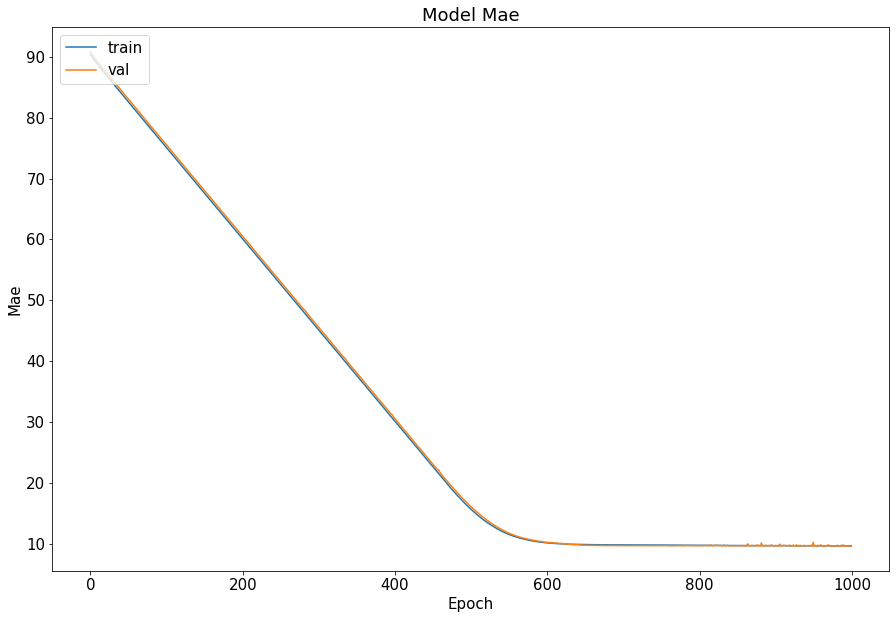

In [15]:
print(history.history.keys())

import matplotlib.pyplot as plt

# summarizing historical accuracy
plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 15})
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Mae')
plt.ylabel('Mae')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Bland-Altman')

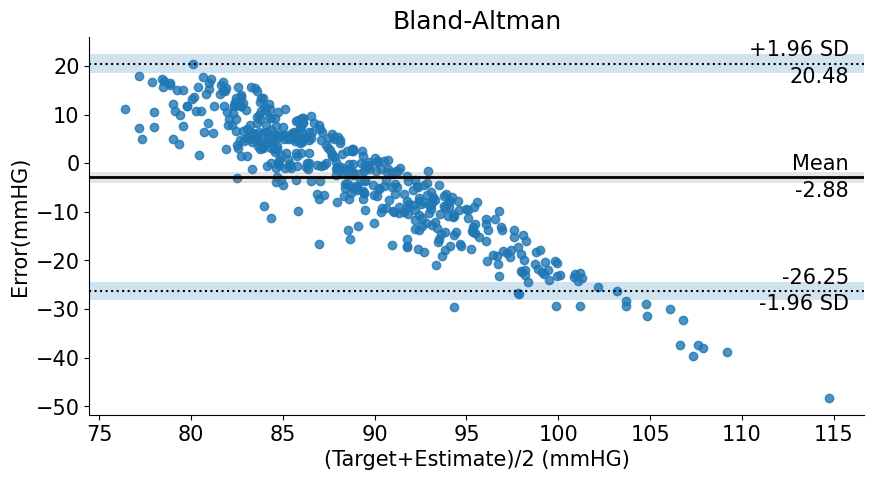

In [16]:
import numpy as np
import pingouin as pg

x=y_pred.reshape(-1)
#ax = pg.plot_blandaltman(y_pred, (y_test+y_pred)/2,figsize=(10, 5))
ax = pg.plot_blandaltman(x, y_test ,figsize=(10, 5))
plt.rcParams.update({'font.size': 15})
plt.xlabel("(Target+Estimate)/2 (mmHG)") #預測與真實的平均值
plt.ylabel("Error(mmHG)") #預測與真實的差值
plt.title("Bland-Altman")

464


Text(0.5, 1.0, 'Histogram of Error')

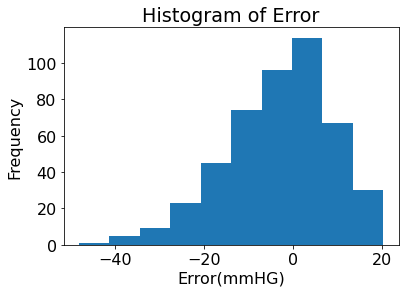

In [17]:
import matplotlib.pyplot as plt

x=y_pred.reshape(-1)
err = x - y_test
print(len(err))
plt.rcParams.update({'font.size': 16})
plt.hist(err)
plt.xlabel("Error(mmHG)")
plt.ylabel("Frequency")
plt.title("Histogram of Error")